In [1]:
import subprocess
import os

result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value

In [2]:
import os
import argparse
from importlib.machinery import SourceFileLoader

import torch

from tokenizer.fr_en_tokenizer import Tokenizer

from models.transformer import TranslationTransformer
from utils.helper import MaskMaker, format_shifted_tgt

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# device
device = torch.device(
    "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
)

In [4]:
global_src_text = "Ce dont vous avez peur n’est jamais aussi grave que ce que vous imaginez. La peur que vous laissez s'accumuler dans votre esprit est pire que la situation qui existe réellement"
global_tgt_text = 'What you are afraid of is never as bad as what you imagine. The fear you let build up in your mind is worse than the situation that actually exists.'

# Forward Utils

In [5]:
def test(model, src_text, tgt_text, wrapped_tokenizer, device='cpu'):
    src = wrapped_tokenizer.tokenize_src(src_text)
    src = src.to(device)
    tgt = wrapped_tokenizer.tokenize_tgt(tgt_text)
    input_tgt, output_tgt = format_shifted_tgt(tgt)
    input_tgt = input_tgt.to(device)
    output_tgt = output_tgt.to(device)
    # -> [1, seq_len]

    mask_maker = MaskMaker(wrapped_tokenizer)

    masks = mask_maker.create_masks(src, input_tgt)

    output = model(src=src, tgt=input_tgt, masks=masks)

    # decode
    output = torch.argmax(output, dim=-1)

    print('src_text:', src_text)
    print('src_tokens:', src)
    print('')
    print('tgt_text:', tgt_text)
    print('input_tgt_tokens:', input_tgt)
    print('output_tgt_tokens:', output_tgt)
    print('')
    print('output_text:', wrapped_tokenizer.decode_output(output[0]))
    print('output_tokens: ', output)

In [6]:
def create_model(args):
    # config
    config = SourceFileLoader('config', args['config']).load_module()
    model_params = config.model_params
    train_params = config.train_params
    valid_params = config.valid_params

    # tokenizer
    wrapped_tokenizer = Tokenizer(model_params['seq_len'])

    model_params['src_vocab_size'] = wrapped_tokenizer.src_vocab_size
    model_params['tgt_vocab_size'] = wrapped_tokenizer.tgt_vocab_size
    # model
    model = TranslationTransformer(config=model_params)
    model_dict = torch.load(args['model_path'])
    # print(model_dict)
    model.load_state_dict(model_dict['model'])
    model = model.to(device)
    model.eval()

    return model, wrapped_tokenizer, model_params

In [7]:
class AttnVis(object):

    def __init__(self, model, wrapped_tokenizer, model_params):
        self.model = model
        self.wrapped_tokenizer = wrapped_tokenizer

        self.encoder_attention = []

        # encoder attention
        for i in range(model_params['num_encoder_layers']):
            self.model.model.encoder.layers[i].self_attn.register_forward_hook(lambda module, input, output: self.get_encoder_attention(module, input, output))

    def get_encoder_attention(self, module, input, output):
        self.encoder_attention.append(output[1])

    def plot_encoder_attention(self):
        fig, axs = plt.subplots(2, 3, figsize=(30, 15))
        for i, attn_w in enumerate(self.encoder_attention):
            attn_w = attn_w[0].detach().cpu().numpy()
            sns.heatmap(attn_w, ax=axs[i//3, i%3], xticklabels=10, yticklabels=10)
            axs[i//3, i%3].set_title(f'Encoder Layer {i+1}')
        plt.show()

# Sinusoidal Position Encoding

In [8]:
args = {
    'model_path': 'runs/transformer_512dh8_e6d6_epochbased_sinusoidal_20240515_224821/checkpoints/best_checkpoint_checkpoint_19_loss=-2.1470.pt',
    'config': 'configs/transformer_512dh8_e6d6_epochbased_sinusoidal.py'
}

sinusoidal_attn_vis = AttnVis(*create_model(args))

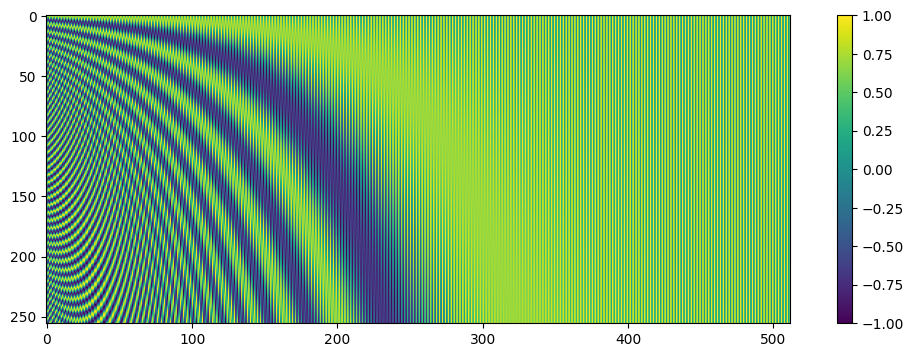

In [9]:
# 热力图可视化 sinusoidal encoding
plt.figure(figsize=(12, 4))
plt.imshow(sinusoidal_attn_vis.model.positional_encoding.pe[0].to('cpu'), aspect='auto')
plt.colorbar()
plt.show()

In [10]:
test(model=sinusoidal_attn_vis.model,
     src_text=global_src_text,
     tgt_text=global_tgt_text, 
     wrapped_tokenizer=sinusoidal_attn_vis.wrapped_tokenizer, 
     device=device)

src_text: Ce dont vous avez peur n’est jamais aussi grave que ce que vous imaginez. La peur que vous laissez s'accumuler dans votre esprit est pire que la situation qui existe réellement
src_tokens: tensor([[  335,   284,    88,   867,  5159,    81,     1,    82,  1161,   231,
          3473,    29,    66,    29,    88, 31867,   590,     3,    80,  5159,
            29,    88, 14436,    62,     6, 37841,    31,   193,  5616,    43,
         12585,    29,     8,   318,    44,  1969,  8909]], device='cuda:0')

tgt_text: What you are afraid of is never as bad as what you imagine. The fear you let build up in your mind is worse than the situation that actually exists.
input_tgt_tokens: tensor([[59514,   430,    55,    52, 10125,     7,    32,  1440,    48,  4339,
            48,   270,    55, 14850,     3,    35,  6491,    55,  1882,  3344,
           205,    18,   117,  2590,    32, 10635,   232,     4,   318,    33,
          3543,  8537,     3]], device='cuda:0')
output_tgt_tokens: tens

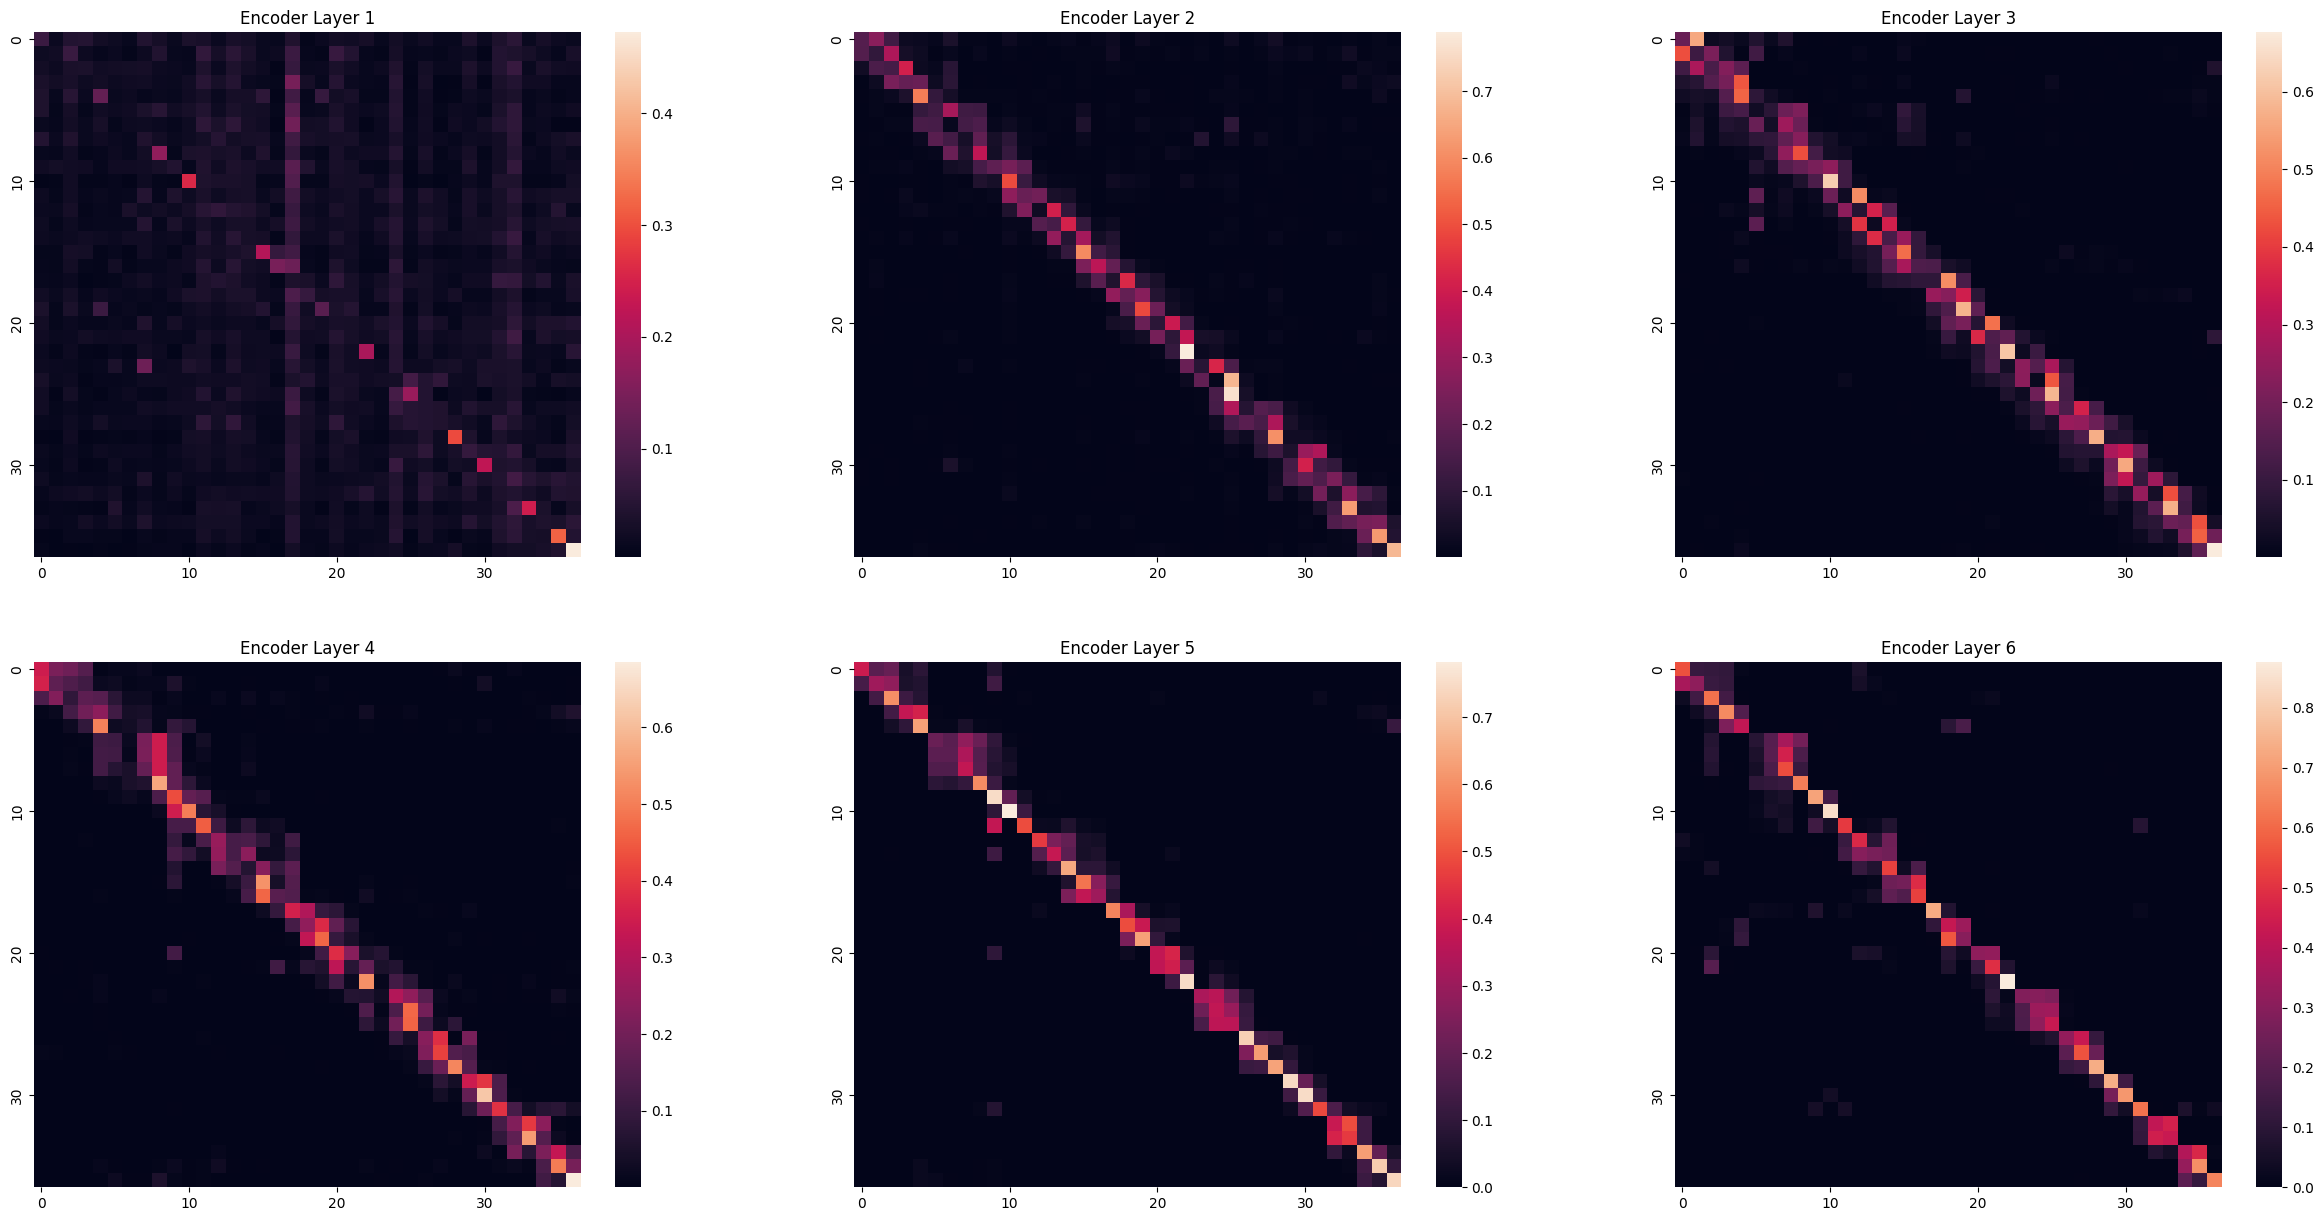

In [11]:
sinusoidal_attn_vis.plot_encoder_attention()

# Learnable Positional Encoding

In [12]:
args = {
    'model_path': 'runs/transformer_512dh8_e6d6_epochbased_learnable_20240516_102957/checkpoints/best_checkpoint_checkpoint_20_loss=-2.2404.pt',
    'config': 'configs/transformer_512dh8_e6d6_epochbased_learnable.py'
}

learnable_attn_vis = AttnVis(*create_model(args))

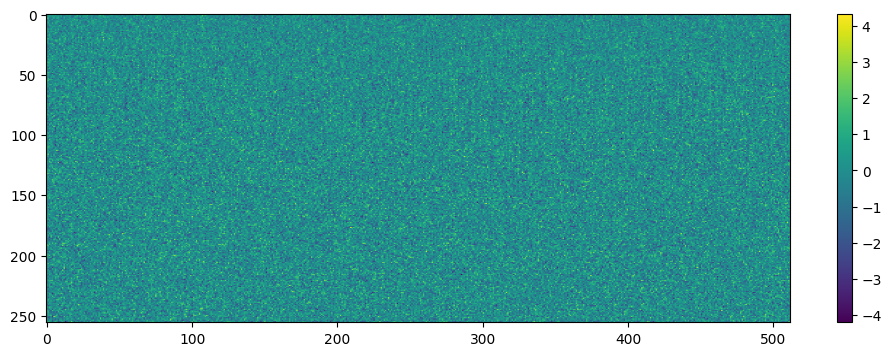

In [13]:
# 热力图可视化 learnable encoding
plt.figure(figsize=(12, 4))
plt.imshow(learnable_attn_vis.model.positional_encoding.learnable_pos(
    learnable_attn_vis.model.positional_encoding.pos_ids).squeeze(0).to('cpu').detach().numpy(), aspect='auto')
plt.colorbar()
plt.show()

In [14]:
test(model=learnable_attn_vis.model,
     src_text=global_src_text,
     tgt_text=global_tgt_text, 
     wrapped_tokenizer=learnable_attn_vis.wrapped_tokenizer, 
     device=device)

src_text: Ce dont vous avez peur n’est jamais aussi grave que ce que vous imaginez. La peur que vous laissez s'accumuler dans votre esprit est pire que la situation qui existe réellement
src_tokens: tensor([[  335,   284,    88,   867,  5159,    81,     1,    82,  1161,   231,
          3473,    29,    66,    29,    88, 31867,   590,     3,    80,  5159,
            29,    88, 14436,    62,     6, 37841,    31,   193,  5616,    43,
         12585,    29,     8,   318,    44,  1969,  8909]], device='cuda:0')

tgt_text: What you are afraid of is never as bad as what you imagine. The fear you let build up in your mind is worse than the situation that actually exists.
input_tgt_tokens: tensor([[59514,   430,    55,    52, 10125,     7,    32,  1440,    48,  4339,
            48,   270,    55, 14850,     3,    35,  6491,    55,  1882,  3344,
           205,    18,   117,  2590,    32, 10635,   232,     4,   318,    33,
          3543,  8537,     3]], device='cuda:0')
output_tgt_tokens: tens

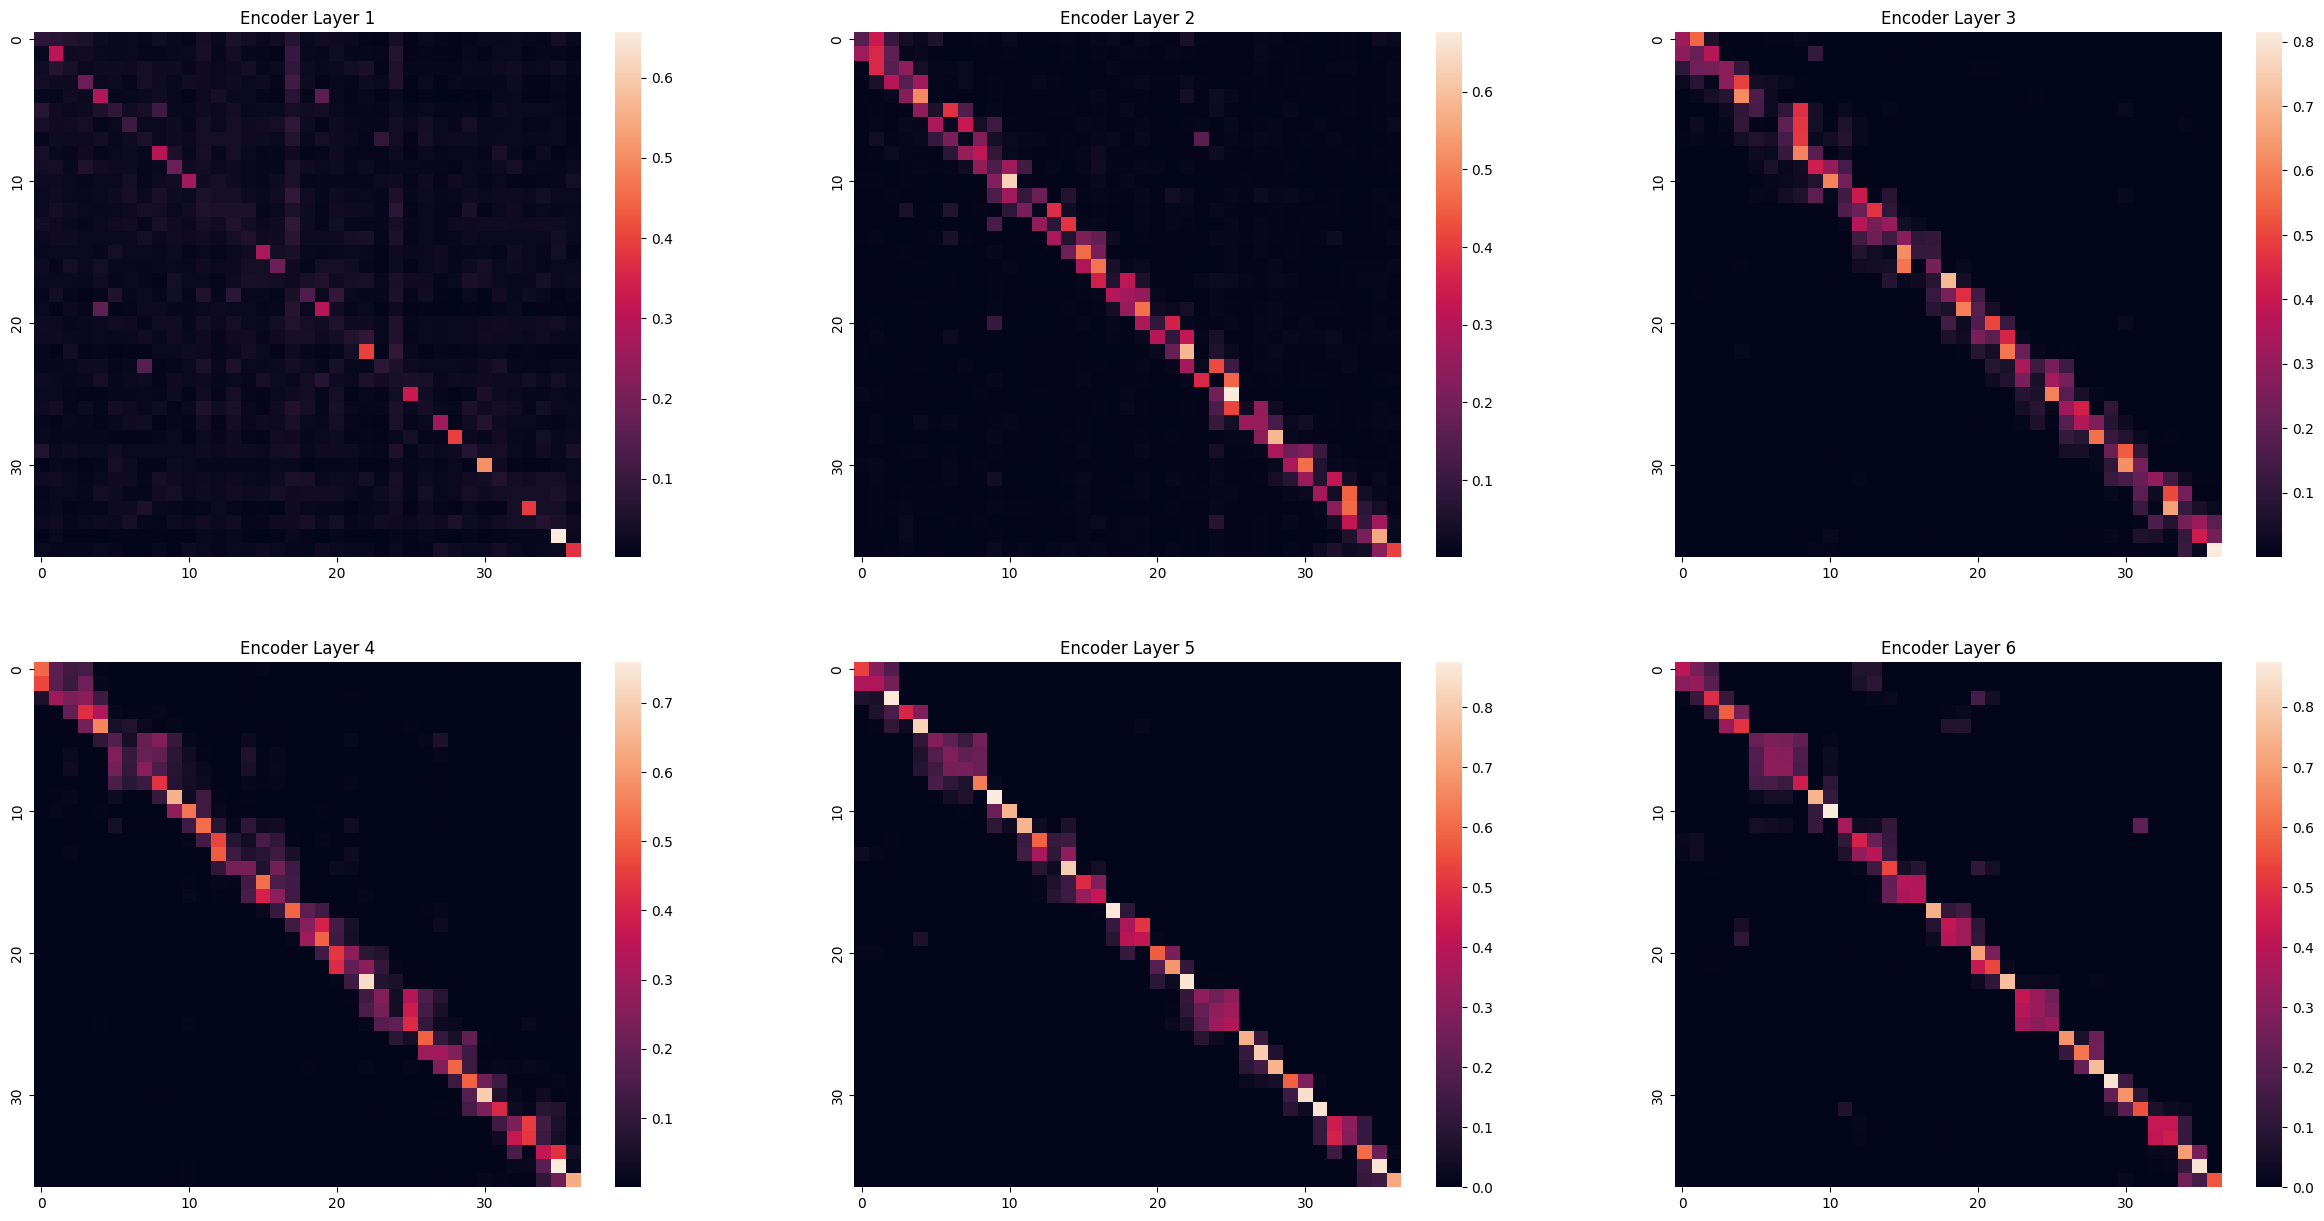

In [15]:
learnable_attn_vis.plot_encoder_attention()

# RoPE

In [16]:
args = {
    'model_path': 'runs/transformer_512dh8_e6d6_epochbased_rope_20240516_011720/checkpoints/best_checkpoint_checkpoint_19_loss=-1.7915.pt',
    'config': 'configs/transformer_512dh8_e6d6_epochbased_rope.py'
}

rope_attn_vis = AttnVis(*create_model(args))

In [17]:
test(model=rope_attn_vis.model,
     src_text=global_src_text,
     tgt_text=global_tgt_text, 
     wrapped_tokenizer=rope_attn_vis.wrapped_tokenizer, 
     device=device)

src_text: Ce dont vous avez peur n’est jamais aussi grave que ce que vous imaginez. La peur que vous laissez s'accumuler dans votre esprit est pire que la situation qui existe réellement
src_tokens: tensor([[  335,   284,    88,   867,  5159,    81,     1,    82,  1161,   231,
          3473,    29,    66,    29,    88, 31867,   590,     3,    80,  5159,
            29,    88, 14436,    62,     6, 37841,    31,   193,  5616,    43,
         12585,    29,     8,   318,    44,  1969,  8909]], device='cuda:0')

tgt_text: What you are afraid of is never as bad as what you imagine. The fear you let build up in your mind is worse than the situation that actually exists.
input_tgt_tokens: tensor([[59514,   430,    55,    52, 10125,     7,    32,  1440,    48,  4339,
            48,   270,    55, 14850,     3,    35,  6491,    55,  1882,  3344,
           205,    18,   117,  2590,    32, 10635,   232,     4,   318,    33,
          3543,  8537,     3]], device='cuda:0')
output_tgt_tokens: tens

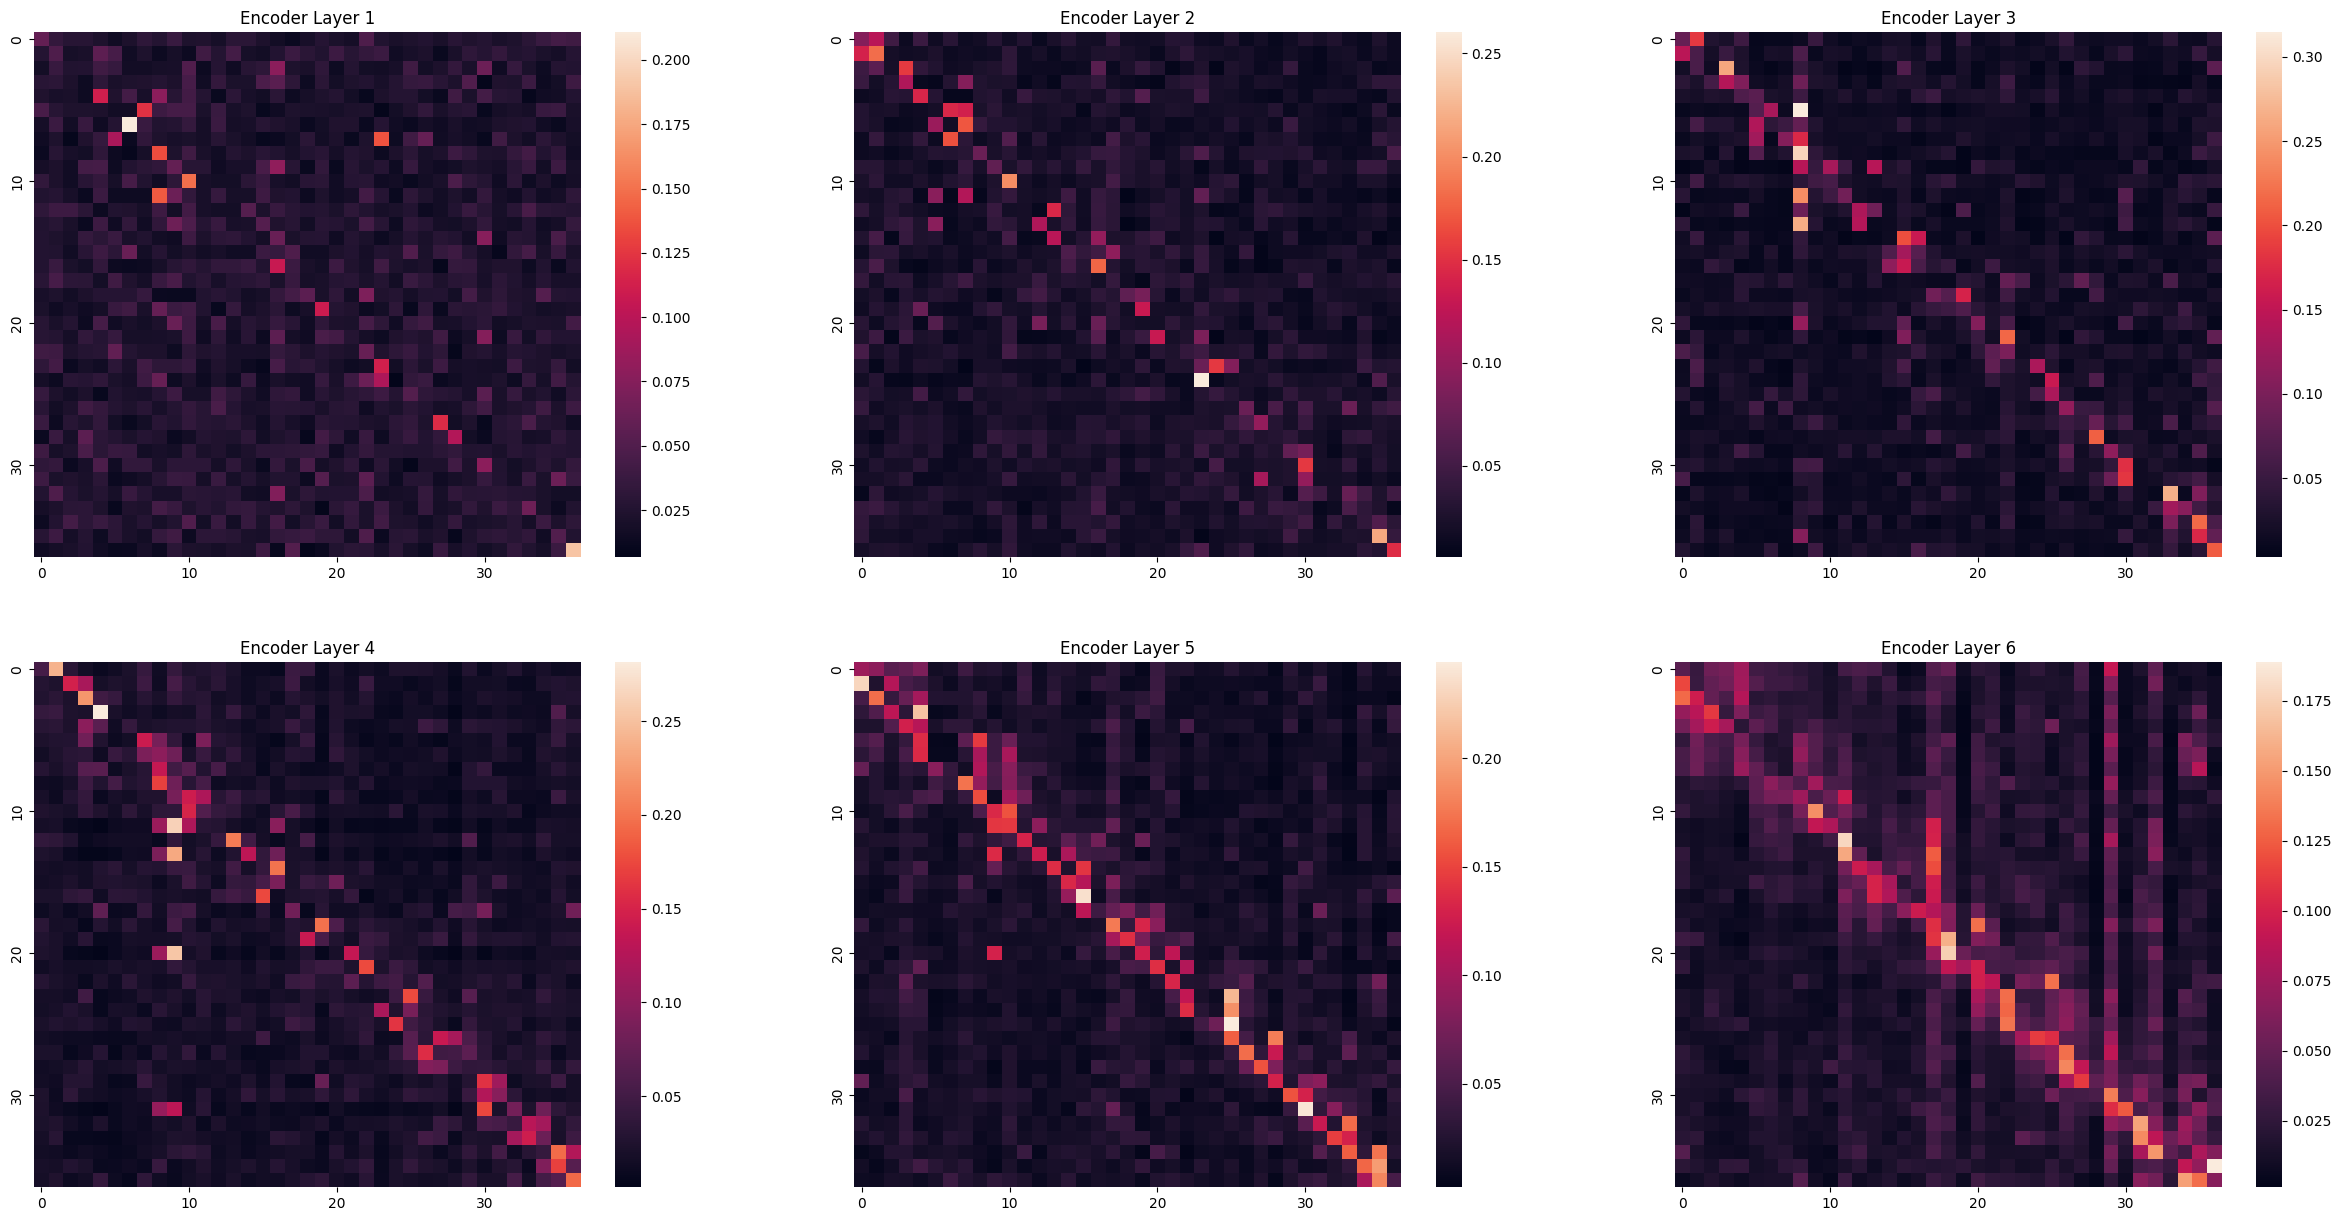

In [18]:
rope_attn_vis.plot_encoder_attention()

In [19]:
rope_attn_vis.wrapped_tokenizer.src_tokenizer.decode([1161, 231,], skip_special_tokens=True)

'jamais aussi'